In [1]:
import logging
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
import cv2
import torch
import torch.nn.functional as F
import math
import pandas as pd
import PIL.Image as Image
from torchvision.transforms import ToTensor, ToPILImage
import torch.nn.functional as F
import segmentation_models_pytorch as smp
from collections import OrderedDict
import torch
import torch.nn as nn
import PIL.Image as Image
from torchvision.transforms import ToTensor, ToPILImage
import torch.nn.functional as F
import pickle
from tqdm import tqdm_notebook as tqdm
import torchvision
import time
from collections import defaultdict
from torch.nn import CTCLoss
from Levenshtein import distance
import random
from torch.utils import data
from torch.utils.data import DataLoader
import collections

In [2]:
class ImageDataset(data.Dataset):
    """
    Dataset class for handwritten lines.

    Parameters
    ----------
    pickle_file : str
        Path to a dataset pickle file.
    meta : bool
        If True, meta data about files is provided.
    num_imgs : int, optional (default=-1)
        Choose only `num_imgs` imgs for processing. If set to -1, uses all available images.

    """

    def __init__(self, pickle_file, meta=False, num_imgs=-1):
        with open(pickle_file, 'rb') as f:
            dataset = pickle.load(f)
        self.reference_dataset = dataset
        self.num_imgs = num_imgs
        if (self.num_imgs > 0) and (self.num_imgs < len(self.reference_dataset)):
            inds = np.random.choice(np.arange(len(self.reference_dataset)),
                                    self.num_imgs, replace=False)
            self.reference_dataset = [self.reference_dataset[i] for i in inds]
        self.meta = meta

    def __getitem__(self, idx):
        data = self.reference_dataset[idx]
        #img = cv2.imread(data['img_path'], cv2.IMREAD_UNCHANGED) / 255.
        img = cv2.resize(cv2.cvtColor(cv2.imread(data['img_path']), cv2.COLOR_BGR2RGB), (442, 64)) / 255.
        img = torch.from_numpy(img).permute(2,0,1).float()
        text = data['description']
        width = data['width']
        height = data['height']

        if self.meta:
            return img, text, data, width, height
        else:
            return img, text

    def __len__(self):
        return len(self.reference_dataset)

In [3]:
SOS_TOKEN = 0  # special token for start of sentence
EOS_TOKEN = 1  # special token for end of sentence

class ConvertBetweenStringAndLabel(object):
    """Convert between str and label.
    NOTE:
        Insert `EOS` to the alphabet for attention.
    Args:
        alphabet (str): set of the possible characters.
        ignore_case (bool, default=True): whether or not to ignore all of the case.
    """

    def __init__(self, alphabet):
        self.alphabet = alphabet

        self.dict = {}
        self.dict['SOS_TOKEN'] = SOS_TOKEN
        self.dict['EOS_TOKEN'] = EOS_TOKEN
        for i, item in enumerate(self.alphabet):
            self.dict[item] = i + 2

    def encode(self, text):
        """
        Args:
            text (str or list of str): texts to convert.
        Returns:
            torch.IntTensor targets:max_length × batch_size
        """
        if isinstance(text, str):
            text = [self.dict[item] if item in self.dict else 2 for item in text]
        elif isinstance(text, collections.Iterable):
            text = [self.encode(s) for s in text]
            max_length = max([len(x) for x in text])
            nb = len(text)
            targets = torch.ones(nb, max_length + 2) * 2
            for i in range(nb):
                targets[i][0] = 0
                targets[i][1:len(text[i]) + 1] = text[i]
                targets[i][len(text[i]) + 1] = 1
            text = targets.transpose(0, 1).contiguous()
            text = text.long()
        return torch.LongTensor(text)

    def decode(self, t):
        """Decode encoded texts back into strs.
        Args:
            torch.IntTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
            torch.IntTensor [n]: length of each text.
        Raises:
            AssertionError: when the texts and its length does not match.
        Returns:
            text (str or list of str): texts to convert.
        """

        texts = list(self.dict.keys())[list(self.dict.values()).index(t)]
        return texts


In [4]:
class CNN(nn.Module):

    def __init__(self, channel_size):
        super(CNN, self).__init__()
        self.cnn = nn.Sequential(
                      nn.Conv2d(channel_size, 64, 3, 1, 1), nn.ReLU(True), nn.MaxPool2d(2, 2),
                      nn.Conv2d(64, 128, 3, 1, 1), nn.ReLU(True), nn.MaxPool2d(2, 2),
                      nn.Conv2d(128, 256, 3, 1, 1), nn.BatchNorm2d(256), nn.ReLU(True),
                      nn.Conv2d(256, 256, 3, 1, 1), nn.ReLU(True), nn.MaxPool2d((2,2), (2,1), (0,1)),
                      nn.Conv2d(256, 512, 3, 1, 0), nn.BatchNorm2d(512), nn.ReLU(True),
                      nn.Conv2d(512, 512, 3, 1, 0), nn.ReLU(True), nn.MaxPool2d((2,2), (2,1), (0,1)),
                      nn.Conv2d(512, 512, 2, 1, 0), nn.BatchNorm2d(512), nn.ReLU(True))

    def forward(self, input):
        # [n, channel_size, 32, 280] -> [n, 512, 1, 71]
        conv = self.cnn(input)
        return conv


class BidirectionalLSTM(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(BidirectionalLSTM, self).__init__()

        self.rnn = nn.LSTM(input_size, hidden_size, bidirectional=True)
        self.embedding = nn.Linear(hidden_size * 2, output_size)

    def forward(self, input):
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)

        output = self.embedding(t_rec)  # [T * b, output_size]
        output = output.view(T, b, -1)
        return output


class AttnDecoderRNN(nn.Module):

    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=71):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)


    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(self.attn(torch.cat((embedded, hidden[0]), 1)), dim=1)
        print('Attn', attn_weights.unsqueeze(1).shape)
        print('Enc',encoder_outputs.permute(1, 0, 2).unsqueeze(1).shape)
        attn_applied = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs.permute(1, 0, 2))

        output = torch.cat((embedded, attn_applied.squeeze(1)), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


class Encoder(nn.Module):
    def __init__(self, channel_size, hidden_size):
        super(Encoder, self).__init__()
        self.cnn = CNN(channel_size)
        self.rnn = nn.Sequential(
            BidirectionalLSTM(512, hidden_size, hidden_size),
            BidirectionalLSTM(hidden_size, hidden_size, hidden_size))

    def forward(self, input):
        # conv features
        conv = self.cnn(input)
        print(conv.shape)
        b, c, h, w = conv.size()
        assert h == 1, "the height of conv must be 1"

        # rnn feature
        conv = conv.squeeze(2)        # [b, c, 1, w] -> [b, c, w]
        conv = conv.permute(2, 0, 1)  # [b, c, w] -> [w, b, c]
        output = self.rnn(conv)
        return output


class Decoder(nn.Module):

    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=71):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.decoder = AttnDecoderRNN(hidden_size, output_size, dropout_p, max_length)

    def forward(self, input, hidden, encoder_outputs):
        return self.decoder(input, hidden, encoder_outputs)

    def initHidden(self, batch_size):
        result = torch.autograd.Variable(torch.zeros(1, batch_size, self.hidden_size))
        return result

In [5]:
def train_on_batch(images, texts, encoder, decoder, criterion, encoder_optimizer,
          decoder_optomizer,device):

    batch_size = images.size(0)

    for encoder_param, decoder_param in zip(encoder.parameters(), decoder.parameters()):
        encoder_param.requires_grad = True
        decoder_param.requires_grad = True
    encoder.train()
    decoder.train()

    target_variable = converter.encode(texts)

    # CNN + BiLSTM
    encoder_outputs = encoder(images.to(device))
    target_variable = target_variable.to(device)
    # start decoder for SOS_TOKEN
    decoder_input = target_variable[SOS_TOKEN].to(device)
    decoder_hidden = decoder.initHidden(batch_size).to(device)

    loss = 0.0
    for di in range(1, target_variable.shape[0]):
        decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
        loss += criterion(decoder_output, target_variable[di])
        topv, topi = decoder_output.data.topk(1)
        ni = topi.squeeze()
        decoder_input = ni

    encoder.zero_grad()
    decoder.zero_grad()
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item()

    
        
def val_on_batch(images, texts, encoder, decoder, criterion,
                 device):

    for e, d in zip(encoder.parameters(), decoder.parameters()):
        e.requires_grad = False
        d.requires_grad = False

    encoder.eval()
    decoder.eval()

    n_correct = 0
    n_total = 0

    batch_size = images.size(0)

    target_variable = converter.encode(texts)
    n_total += len(cpu_texts[0]) + 1

    decoded_words = []
    decoded_label = []
    encoder_outputs = encoder(images)
    target_variable = target_variable.to(device)
    decoder_input = target_variable[0].to(device)
    decoder_hidden = decoder.initHidden(batch_size).to(device)

    for di in range(1, target_variable.shape[0]):
        decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
        topv, topi = decoder_output.data.topk(1)
        ni = topi.squeeze(1)
        decoder_input = ni
        if ni == EOS_TOKEN:
            decoded_label.append(EOS_TOKEN)
            break
        else:
            decoded_words.append(converter.decode(ni))
            decoded_label.append(ni)

    for pred, target in zip(decoded_label, target_variable[1:,:]):
        if pred == target:
            n_correct += 1

    accuracy = n_correct / float(n_total)

    return loss.item(), accuracy

In [6]:
pickle_path_train = '/home/storage/3020/KrivorotovI/db/HKR/datasets/train.pkl'
pickle_path_val = '/home/storage/3020/KrivorotovI/db/HKR/datasets/val.pkl'
with open(pickle_path_train, 'rb') as f:
    full_dataset = pickle.load(f)
alphabet = ''
for example in full_dataset:
    alphabet += example['description']
alphabet = list(set(alphabet))
alphabet =''.join(alphabet)
len(alphabet)

79

In [7]:
hidden_size = 256
output_size = len(alphabet) + 2
max_length = 64
batch_size = 64

In [8]:
device = torch.device("cuda:3")

converter = ConvertBetweenStringAndLabel(alphabet)
encoder = Encoder(channel_size=3, hidden_size=hidden_size)
decoder = Decoder(hidden_size, output_size, dropout_p=0.1, max_length=max_length)
encoder.to(device)
decoder.to(device)
ocr_loss = torch.nn.NLLLoss()
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=0.0001, betas=(0.5, 0.999))
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=0.0001, betas=(0.5, 0.999))
train_dataset = ImageDataset(pickle_path_train, num_imgs=-1)
val_dataset = ImageDataset(pickle_path_val, num_imgs=-1)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=1, drop_last = True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=1, drop_last = True)

torch.Size([64, 3, 64, 442])
Актюбинская


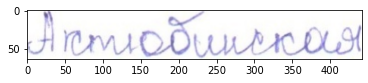

In [9]:
for imgs, text in train_dataloader:
    print(imgs.shape)
    plt.imshow(imgs[0].permute(1,2,0))
    print(text[0])
    break

In [10]:
ep = 100

train_loss = []
train_acc_char = []
train_acc_str = []
train_cer = []

val_loss = []
val_acc_char = []
val_acc_str = []
val_cer = []

best_str_acc = 0

for epoch in range(ep):
    train_epoch_loss = []
    
    train_epoch_acc_char = []
    train_epoch_acc_str = []
    train_epoch_cer = []
    
    with tqdm(total = len(train_dataloader), ncols='100%') as bar_train:
        for i, (images, gt_text) in enumerate(train_dataloader):

            results = train_on_batch(images, gt_text, encoder, decoder, ocr_loss, encoder_optimizer,
                                          decoder_optimizer,device)
            loss = results
            
            train_epoch_loss.append(loss)
            #train_epoch_acc_char.append(acc_char)
            #train_epoch_acc_str.append(acc_str)
            #train_epoch_cer.append(cer)

            printed_data = f"Ep: {epoch}. Train loss: {np.mean(train_epoch_loss):.4f}."
            bar_train.set_description(printed_data)
            bar_train.update(1)
            
    train_loss.append(np.mean(train_epoch_loss))
    
    #train_acc_char.append(np.mean(train_epoch_acc_char))
    #train_acc_str.append(np.mean(train_epoch_acc_str))
    #train_cer.append(np.mean(train_epoch_cer))
    
    
    val_epoch_loss = []
    
    val_epoch_acc_char = []
    val_epoch_acc_str = []
    val_epoch_cer = []
    
    with tqdm(total = len(val_dataloader), ncols='100%') as bar_val:
        for i, (images, gt_text) in enumerate(val_dataloader):

            results = val_on_batch_rec(images, gt_text, net, ocr_loss, device, batch_size, converter)
            loss, acc_char, acc_str, cer, decode_text, gt_text, raw_preds = results
            
            val_epoch_loss.append(loss)
            val_epoch_acc_char.append(acc_char)
            val_epoch_acc_str.append(acc_str)
            val_epoch_cer.append(cer)

            printed_data = f"Ep: {epoch}. Val loss: {np.mean(val_epoch_loss):.4f}.\
            Acc char: {np.mean(val_epoch_acc_char):.4f}.\
            Acc str: {np.mean(val_epoch_acc_str):.4f}.\
            CER: {np.mean(val_epoch_cer):.4f}."
            bar_val.set_description(printed_data)
            bar_val.update(1)
        
    val_loss.append(np.mean(val_epoch_loss))
    
    val_acc_char.append(np.mean(val_epoch_acc_char))
    val_acc_str.append(np.mean(val_epoch_acc_str))
    val_cer.append(np.mean(val_epoch_cer))
    
    print('Lr now:', optimizer.param_groups[0]['lr'])

    for raw_pred, pred, gt in zip(raw_preds, decode_text, gt_text):
        print('%-20s => %-20s, gt: %-20s' % (raw_pred, pred, gt)) 
    
    if epoch == 40:
        for g in optimizer.param_groups:
            g['lr'] = g['lr']*0.1
        print('Lr now:', optimizer.param_groups[0]['lr'])
        
    if epoch == 70:
        for g in optimizer.param_groups:
            g['lr'] = g['lr']*0.1
        print('Lr now:', optimizer.param_groups[0]['lr'])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working


torch.Size([64, 512, 1, 107])
Attn torch.Size([64, 1, 64])
Enc torch.Size([64, 1, 107, 256])



RuntimeError: invalid argument 6: wrong matrix size at /pytorch/aten/src/THC/generic/THCTensorMathBlas.cu:41